In [1]:
from flask import Flask, request, jsonify, send_file, send_from_directory
import os
from extract_text import TextExtractor
from stage1 import run_diffusion_1
from stage2 import run_diffusion_2
from heatmap import create_heatmap
from pmap import run_pmap_function
import threading
import io
import sys
from flask_cors import CORS
import pydicom
from dicom_helpers import nifti_to_dicom
import accelerate
import torch
import signal
import subprocess
import time
import numpy as np
from flask import Flask, jsonify, send_file
import cv2
import nibabel as nib
from scipy.ndimage import zoom

/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [2]:
FILES_FOLDER = '/media/volume/gen-ai-volume/MedSyn/results'

# models
TEXTEXTRACTOR_MODEL_FOLDER = "/media/volume/gen-ai-volume/MedSyn/models/test_run2"
STAGE1_MODEL_FOLDER="/media/volume/gen-ai-volume/MedSyn/models/stage1"
STAGE2_MODEL_FOLDER = "/media/volume/gen-ai-volume/MedSyn/models/stage2"

In [3]:
def run_text_extractor_and_models(studyInstanceUID, description, prompt, output_folder, filename, patient_name, patient_id, series_instance_uid, read_img_flag, num_series_exists=0):

    # clear output folder textembedding
    for fn in os.listdir(FILES_FOLDER+"/text_embed"):
        file_path = os.path.join(FILES_FOLDER+"/text_embed", fn)
        if os.path.isfile(file_path) and "dont_delete" not in fn:
            os.remove(file_path)

    
    # clear output folder low-resolution
    if read_img_flag:
        for fn in os.listdir(FILES_FOLDER +"/img_64_standard/" + studyInstanceUID):
            file_path = os.path.join(FILES_FOLDER +"/img_64_standard", fn)
            if os.path.isfile(file_path) and "dont_delete" not in fn:
                if "saved_noise" not in fn:
                    os.remove(file_path)

    try:
        torch.cuda.empty_cache()
        # Run the text extractor
        text_extractor = TextExtractor(resume_model=TEXTEXTRACTOR_MODEL_FOLDER)
        text_extractor.run(prompt, output_folder, filename)
        print(f"Textembedding stored in: {output_folder}")
        
        torch.cuda.empty_cache()
        accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state

        run_diffusion_1(input_folder=FILES_FOLDER+"/text_embed", 
                        output_folder=FILES_FOLDER +"/img_64_standard/" + studyInstanceUID, 
                        noise_folder=FILES_FOLDER+"/img_64_standard/saved_noise/" + studyInstanceUID,
                        model_folder=STAGE1_MODEL_FOLDER, 
                        dont_delete_folder=FILES_FOLDER+"/img_64_standard",
                        attention_folder=FILES_FOLDER+"/saliency_maps/"+studyInstanceUID,
                        num_sample=1,
                        tokenizer=text_extractor.tokenizer,
                        read_img_flag=read_img_flag,
                        num_series_exists=num_series_exists)
        
        print("Completed low res.")

        torch.cuda.empty_cache()
        accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state

        # Run high-res model
        run_diffusion_2(input_folder=FILES_FOLDER+ "/img_64_standard/"+studyInstanceUID, 
                        output_folder=FILES_FOLDER +"/img_256_standard", 
                        model_folder=STAGE2_MODEL_FOLDER,
                        filename=filename,
                        num_series_exists=num_series_exists)
        
        print("Completed high res.")

        # convert nifti to dicom
        nifti_file = os.path.join(FILES_FOLDER,"img_256_standard",filename[:-4]+"_sample_" + str(num_series_exists) + ".nii.gz")
        output_folder = os.path.join(FILES_FOLDER,"dicom",studyInstanceUID+"_sample_"+str(num_series_exists))
        
        print(series_instance_uid)
        print(nifti_file)
        nifti_to_dicom(nifti_file=nifti_file,
                        output_folder=output_folder,
                        series_description=description,                      
                        series_instance_uid=series_instance_uid,
                        study_instance_uid=studyInstanceUID,
                        patient_name=patient_name,
                        patient_id=patient_id)
        
        print("Now making heatmap and pmap....")
        # first we need to get the heatmap volume
        heatmap_data_path = FILES_FOLDER+'/saliency_maps/'+studyInstanceUID+'/'+filename[:-4]+"_sample_" + str(num_series_exists)+'_token_0_[CLS]_heatmaps.npy'
        hm_vol = create_heatmap(heatmap_data_path)

        print('Now maknig pmap...')
        out_path = run_pmap_function(studyInstanceUID, hm_vol, num_series_exists, 0.8)
        print(f"We saved the pmap at {out_path}")
        out_path = run_pmap_function(studyInstanceUID, hm_vol, num_series_exists, 0.8, saliencymap=True, saliencythresh=False)
        print("Saving saliency map: ", out_path)
        out_path = run_pmap_function(studyInstanceUID, hm_vol, num_series_exists, 0.8, saliencymap=False, saliencythresh=True)
        print("Saving saliency map threshold: ", out_path)
        
    finally:
        print("Uploading Data to Orthanc...")

In [4]:
description="Normal Chest"

run_text_extractor_and_models(
    studyInstanceUID="111222333",
    description=description, 
    prompt="no right pleural effusion, no consolidation, no left pleural effusion",
    output_folder="/media/volume/gen-ai-volume/MedSyn/results/text_embed",
    filename="111222333.npy",
    patient_name="111222333",
    patient_id="1010101112223332907",
    series_instance_uid="111222333",
    read_img_flag=False,
    num_series_exists=0
)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of CXRBertModel were not initialized from the model checkpoint at microsoft/BiomedVLP-CXR-BERT-specialized and are newly initialized: ['classifier.bias

<All keys matched successfully>
(1, 192, 768)
Saved to: /media/volume/gen-ai-volume/MedSyn/results/text_embed/111222333.npy
Saved rokens to: /media/volume/gen-ai-volume/MedSyn/results/text_embed/111222333_tokens.npy
Textembedding stored in: /media/volume/gen-ai-volume/MedSyn/results/text_embed


/home/exouser/MedsynBackend/src/stage1.py:1261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=map_location), s

Tokens file missing for dont_delete.npy
found 1 text embedding files at /media/volume/gen-ai-volume/MedSyn/results/text_embed


/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/accelerate/accelerator.py:479: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


loading low-res model...
Pre-saved noise not found! Generating new fixed noise instead.
Debug: Cleared attention_maps, Length is now 0
Low Resolution: 100%|██████████| 51/51 [00:15<00:00,  3.30it/s]
Debug: Appended attention_maps. Length is now 1
Debug: Number of attention maps in the last timestep: 4
ATTENTION PATH:  /media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222333/111222333_sample_0_token_0_[CLS]_heatmaps.npy
Saved heatmap for token '[CLS]' at: /media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222333/111222333_sample_0_token_0_[CLS]_heatmaps.npy
ATTENTION PATH:  /media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222333/111222333_sample_0_token_1_no_heatmaps.npy
Saved heatmap for token 'no' at: /media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222333/111222333_sample_0_token_1_no_heatmaps.npy
ATTENTION PATH:  /media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222333/111222333_sample_0_token_2_right_heatmaps.npy
Saved heatmap for 

/home/exouser/MedsynBackend/src/stage2.py:1110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=map_location), s

found 1 videos as gif files at /media/volume/gen-ai-volume/MedSyn/results/img_64_standard/111222333
loading model...
Load accelerator state: /media/volume/gen-ai-volume/MedSyn/models/stage2/1000_ckpt
training model...
num_samples: 1
High Resolution: 100%|██████████| 21/21 [01:26<00:00,  4.12s/it]
Completed high res.
111222333
/media/volume/gen-ai-volume/MedSyn/results/img_256_standard/111222333_sample_0.nii.gz
Store DICOM files in Folder: /media/volume/gen-ai-volume/MedSyn/results/dicom/111222333_sample_0
Conversion complete. DICOM files are saved in /media/volume/gen-ai-volume/MedSyn/results/dicom/111222333_sample_0
Now making heatmap and pmap....
Loaded heatmaps with shape: (64, 8, 8)
Now maknig pmap...
Resizing PMAP from (64, 64, 64) to (256, 256, 256)


/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/highdicom/valuerep.py:54: UserWarning: The string "111222333" is unlikely to represent the intended person name since it contains only a single component. Construct a person name according to the format in described in https://dicom.nema.org/dicom/2013/output/chtml/part05/sect_6.2.html#sect_6.2.1.2, or, in pydicom 2.2.0 or later, use the pydicom.valuerep.PersonName.from_named_components() method to construct the person name correctly. If a single-component name is really intended, add a trailing caret character to disambiguate the name.
  warnings.warn(


Saved PMAP DICOM to /media/volume/gen-ai-volume/MedSyn/results/dicom_overlays/111222333/111222333_sample_0_output_heatmap.dcm
We saved the pmap at /media/volume/gen-ai-volume/MedSyn/results/dicom_overlays/111222333/111222333_sample_0_output_heatmap.dcm
Uploading Data to Orthanc...


In [4]:
description="Chest with consolidation associated with left pleural effusion"

run_text_extractor_and_models(
    studyInstanceUID="111222333",
    description=description, 
    prompt="left pleural based consolidation associated with mild left pleural effusion",
    output_folder="/media/volume/gen-ai-volume/MedSyn/results/text_embed",
    filename="111222333.npy",
    patient_name="111222333",
    patient_id="1010101112223332907",
    series_instance_uid="111222333_1",
    read_img_flag=True,
    num_series_exists=1
)

FileNotFoundError: [Errno 2] No such file or directory: '/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/111222333'

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

generated_filename = "111222333_sample_0.npy"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/111222333"
image_path = os.path.join(output_folder, generated_filename)

generated_image = np.load(image_path)  # Shape: (C, D, H, W) or (C, num_slices, height, width)
print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions

if generated_image.shape[0] == 1:  # Only squeeze axis=1 if it's 1
    generated_image = np.squeeze(generated_image, axis=0)

print(f"New image shape: {generated_image.shape}")  # Check image dimensions


Loaded image shape: (1, 4, 64, 64, 64)
New image shape: (4, 64, 64, 64)


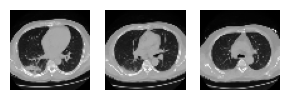

In [6]:
# Select slices for visualization
num_slices = generated_image.shape[2]  # Depth of the image (D)
selected_slices = [24, num_slices // 2, 40]  # Select three slices


plt.figure(figsize=(3, 3))

for i, slice_idx in enumerate(selected_slices):
    original_slice = generated_image[0, slice_idx, :, :]  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[0]  # Take the first channel if multi-channel
    # Flip images upside down
    original_slice = np.flipud(original_slice)
    # attention_slice_resized = np.flipud(attention_slice_resized)
    # Overlay attention
    
    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(3, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

Sample shape: (64, 64, 64)
Loaded heatmaps with shape: (64, 8, 8)
Final heatmap volume shape: (64, 64, 64)


<Figure size 2500x2000 with 0 Axes>

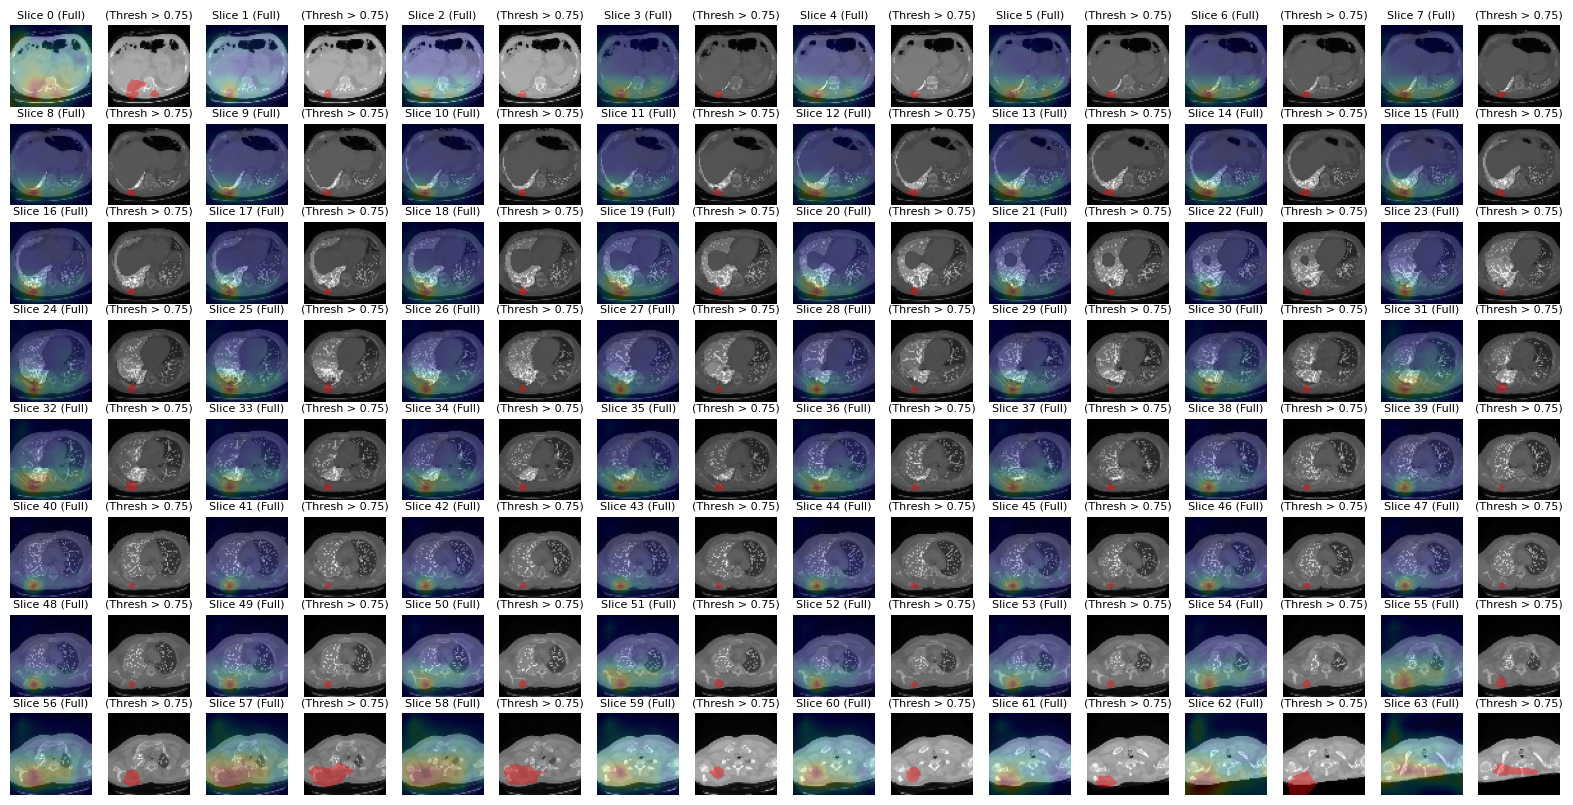

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min + 1e-8)

def overlay_heatmap_on_slices(volume, heatmap_volume, view='axial', n_rows=8, n_cols=8, threshold=0.5):
    if view == 'axial':
        slices = volume
        heatmap_slices = heatmap_volume
    elif view == 'coronal':
        slices = np.transpose(volume, (1, 0, 2))
        heatmap_slices = np.transpose(heatmap_volume, (1, 0, 2))
    elif view == 'sagittal':
        slices = np.transpose(volume, (2, 0, 1))
        heatmap_slices = np.transpose(heatmap_volume, (2, 0, 1))
    else:
        raise ValueError("Invalid view. Choose from 'axial', 'coronal', or 'sagittal'.")

    num_slices = slices.shape[0]
    total_plots = min(n_rows * n_cols, num_slices)  # Prevent index errors
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(20, 10))  # Twice the columns for comparison
    axes = axes.flatten()

    for idx in range(total_plots):
        slice_idx = idx  
        if slice_idx >= num_slices:
            axes[idx * 2].axis('off')
            axes[idx * 2 + 1].axis('off')
            continue

        image_slice = slices[slice_idx, :, :]
        image_slice_norm = normalize_image(image_slice)

        heatmap_slice = heatmap_slices[slice_idx, :, :]
        heatmap_slice_norm = normalize_image(heatmap_slice)

        # Plot full heatmap overlay (Left Column)
        axes[idx * 2].imshow(image_slice_norm, cmap='gray')
        axes[idx * 2].imshow(heatmap_slice_norm, cmap='jet', alpha=0.2)
        axes[idx * 2].set_title(f'Slice {slice_idx} (Full)', fontsize=8)
        axes[idx * 2].axis('off')

        # Plot thresholded red transparent overlay (Right Column)
        threshold_mask = heatmap_slice_norm > threshold
        red_mask = np.zeros((*heatmap_slice_norm.shape, 4))  # RGBA
        red_mask[..., 0] = 1  # Red channel
        red_mask[..., 3] = threshold_mask * 0.4  # Apply alpha where mask is True

        axes[idx * 2 + 1].imshow(image_slice_norm, cmap='gray')
        axes[idx * 2 + 1].imshow(red_mask)
        axes[idx * 2 + 1].set_title(f'(Thresh > {threshold})', fontsize=8)
        axes[idx * 2 + 1].axis('off')

    plt.tight_layout  # Adjust spacing
    plt.show()


heatmap_data_path = '/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222333/111222333_sample_0_token_0_[CLS]_heatmaps.npy'

# Load the generated images
data = generated_image

#add a dummy batch dimension
data_batched = np.expand_dims(data, axis=0)

# Average over channels if multiple channels exist
sample = data_batched[0].mean(axis=0)  # [frames, height, width]
num_frames, height, width = sample.shape
print(f"Sample shape: {sample.shape}")
sample_norm = normalize_image(sample)
heatmaps = np.load(heatmap_data_path)
print(f"Loaded heatmaps with shape: {heatmaps.shape}")


if heatmaps.shape[1] != height or heatmaps.shape[2] != width:
    resized_heatmaps = []
    for i in range(num_frames):
        heatmap_slice = heatmaps[i, :, :]  # e.g. (8, 8)
        heatmap_slice_norm = normalize_image(heatmap_slice)
        zoom_factors = (height / heatmap_slice.shape[0], width / heatmap_slice.shape[1])
        heatmap_resized = zoom(heatmap_slice_norm, zoom_factors, order=1)  # Bilinear interpolation
        resized_heatmaps.append(heatmap_resized)
    heatmap_volume = np.stack(resized_heatmaps, axis=0)  # (frames, height, width)
else:
    heatmap_volume = heatmaps

print(f"Final heatmap volume shape: {heatmap_volume.shape}")
view = 'axial'

# Flip image and heatmap volume upside-down
sample_norm_flipped = np.flip(sample_norm, axis=1)  # Flip vertically
heatmap_volume_flipped = np.flip(heatmap_volume, axis=1)  # Flip heatmap vertically

# Flip left/right
# sample_norm_flipped = np.flip(sample_norm_flipped, axis=2)  # Flip horizontally
# heatmap_volume_flipped = np.flip(heatmap_volume_flipped, axis=2)  # Flip heatmap horizontally

plt.figure(figsize=(25, 20))
overlay_heatmap_on_slices(sample_norm_flipped, heatmap_volume_flipped, view='axial', n_rows=8, n_cols=8, threshold=0.75)

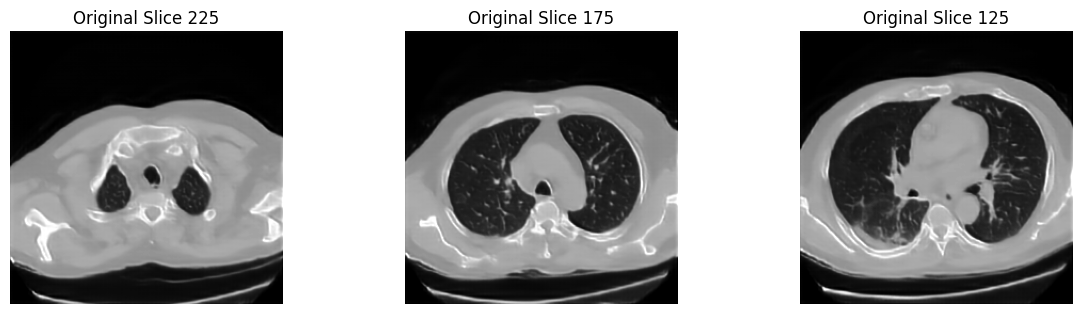

In [8]:
import nibabel as nib 

generated_highres_filename = "111222333_sample_0.nii.gz"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_256_standard/"
image_path = os.path.join(output_folder, generated_highres_filename)

nii_img = nib.load(image_path)

# Convert NIfTI to NumPy array
nii_data = nii_img.get_fdata()  # Shape: (depth, height, width)
nii_data.shape

num_slices_high_res = nii_data.shape[2]
selected_slices_high_res = [225, 175, 125]  # Select three slices

plt.figure(figsize=(12, 9))

for i, slice_idx in enumerate(selected_slices_high_res):
    original_slice = nii_data[:, :, slice_idx]  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[:, :, 0]  # Take the first channel if multi-channel
        
    # Flip images upside down
    original_slice = (np.rot90(original_slice))
    
    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(3, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.title(f"Original Slice {slice_idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()